In [3]:
import src.register_optimizer as regop
import src.QAOA_func as QAOAop
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform
from pulser.devices import DigitalAnalogDevice

import src.register_optimizer as regop

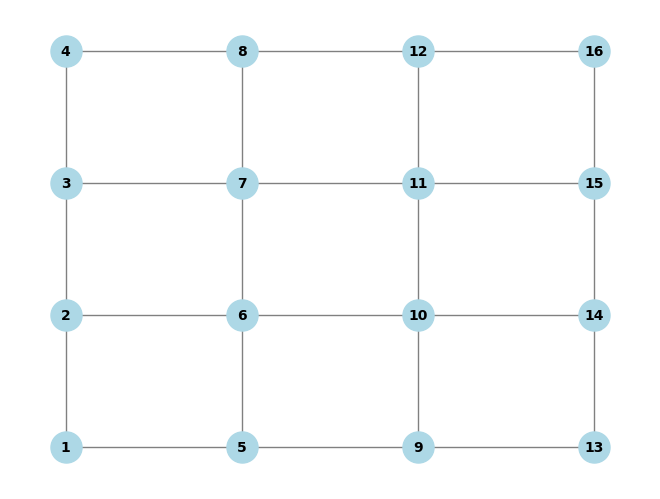

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


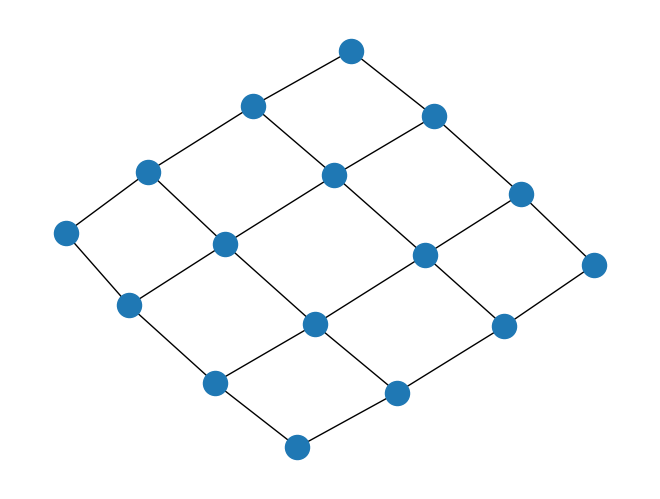

In [36]:
#square graph
import networkx as nx
import matplotlib.pyplot as plt

# Define the size of the lattice (e.g., 5x5)
rows, cols = 4, 4

mapping = {}
counter = 1
for i in range(rows):
    for j in range(cols):
        mapping[(i, j)] = counter
        counter += 1

# Create a 2D grid graph
G = nx.grid_2d_graph(rows, cols)

# Create labels using the mapping
labels = {node: str(mapping[node]) for node in G.nodes()}

# Draw the 2D grid graph
pos = dict((n, n) for n in G.nodes())  # Use node coordinates as positions
# labels = dict(((i, j), f"{i*j}") for i, j in G.nodes())  # Create labels for nodes

nx.draw(G, pos, with_labels=True, labels=labels, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
# plt.title("Square Lattice (5x5)")
plt.show()

print(G.nodes())

nx.draw(G)

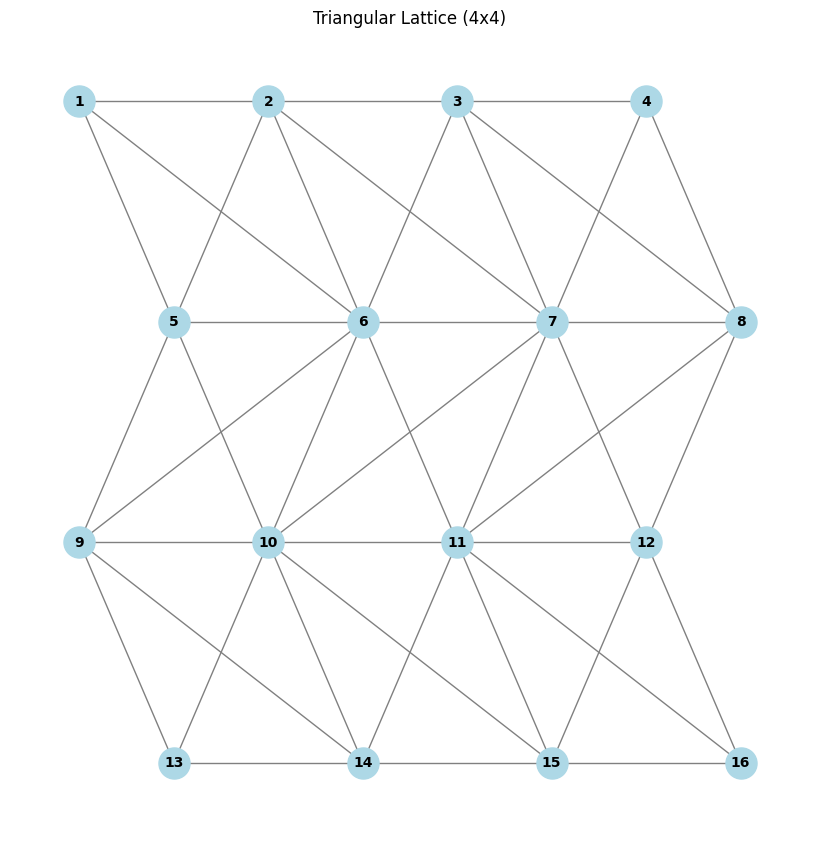

In [25]:
#triangular lattice
import networkx as nx
import matplotlib.pyplot as plt

# Define the size of the lattice (e.g., 4x4)
rows, cols = 4, 4

# Create a graph
G = nx.Graph()

# Create nodes and add them to the graph
for i in range(rows):
    for j in range(cols):
        G.add_node((i, j))

# Create edges for the triangular lattice
for i in range(rows):
    for j in range(cols):
        if j + 1 < cols:  # Horizontal edge
            G.add_edge((i, j), (i, j + 1))
        if i + 1 < rows:  # Vertical edge
            G.add_edge((i, j), (i + 1, j))
        if i + 1 < rows and j + 1 < cols:  # Diagonal edge
            G.add_edge((i, j), (i + 1, j + 1))
        if i + 1 < rows and j - 1 >= 0:  # Another diagonal edge
            G.add_edge((i, j), (i + 1, j - 1))

# Create a mapping from (i, j) to sequential numbers
mapping = {}
counter = 1
for i in range(rows):
    for j in range(cols):
        mapping[(i, j)] = counter
        counter += 1

# Create labels using the mapping
labels = {node: str(mapping[node]) for node in G.nodes()}

# Define positions for a clearer layout
pos = {(i, j): (j + (i % 2) * 0.5, -i) for i, j in G.nodes()}

# Draw the triangular lattice graph
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, labels=labels, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")

# Add a title to the plot
plt.title("Triangular Lattice (4x4)")
plt.show()


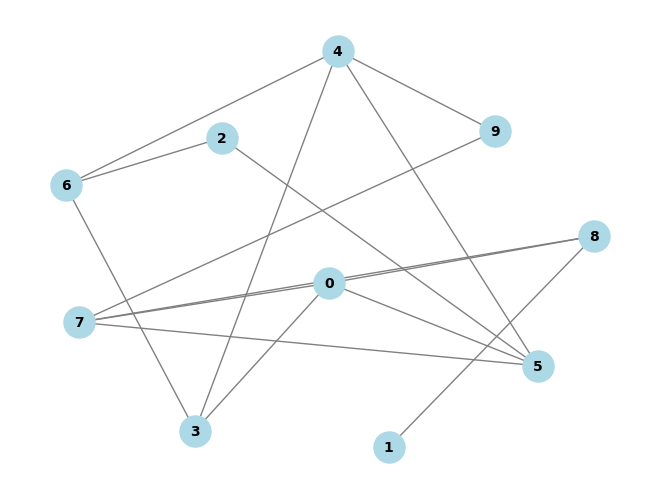

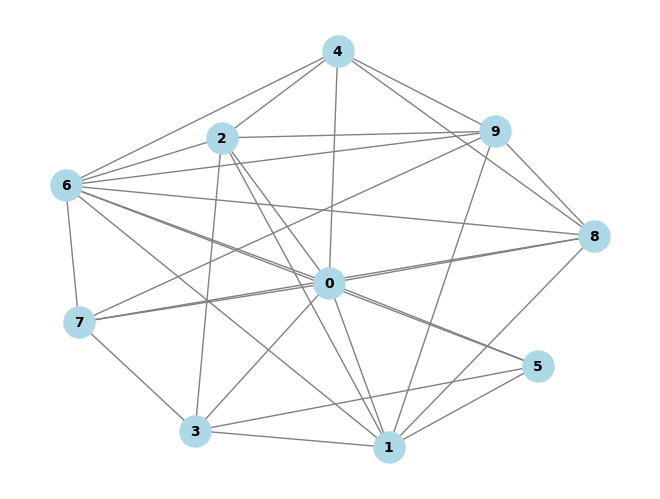

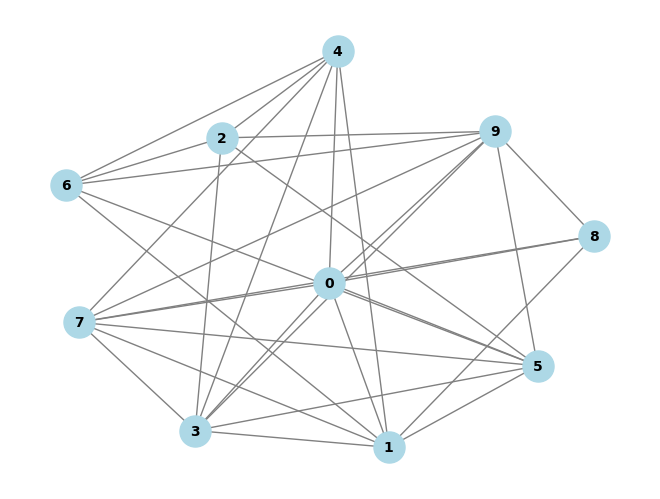

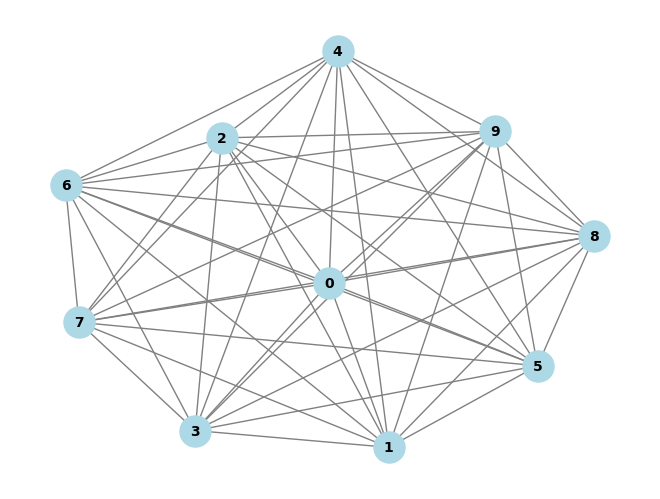

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
# from ipywidgets import interact

def draw_random_graph(n, p):
    # Generate a random graph
    G = nx.erdos_renyi_graph(n, p)    
    return(G,pos)

# Define parameters
n = 10  # Number of nodes

# # Use ipywidgets interact to create an interactive plot
# interact(draw_random_graph, n=(5, 30, 1), p=(0.0, 1.0, 0.01))

for p in [0.3,0.5,0.6,1]:
    G,pos=draw_random_graph(n,p)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10, font_weight="bold", edge_color="gray")
    plt.show()

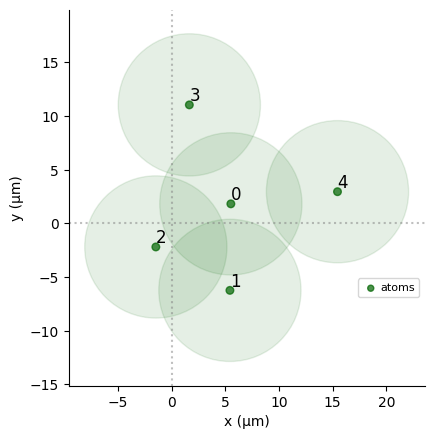

In [6]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

LAYERS=2

reg = regop.optimized_register(Q)
regop.draw_register(reg)


# np.random.seed(123)  # ensures reproducibility of the tutorial
# guess = {
#     "t": np.random.uniform(8, 10, LAYERS),
#     "s": np.random.uniform(1, 3, LAYERS),
# }

# example_dict = QAOAop.quantum_loop(np.r_[guess["t"], guess["s"]],LAYERS)

# QAOAop.plot_distribution(example_dict)


In [11]:
def quantum_loop_circuit(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

def function(param, *args):
    Q = args[0]
    C = quantum_loop_circuit(np.r_[guess["t"], guess["s"]],LAYERS,Q)
    cost = get_cost(C, Q)
    return cost

scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            function,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass


In [10]:
optimal_count_dict = QAOAop.quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)


ValueError: attempt to get argmin of an empty sequence

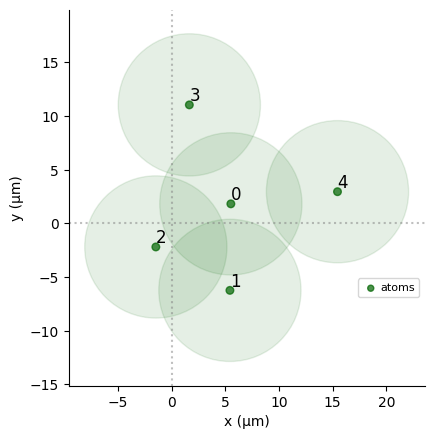

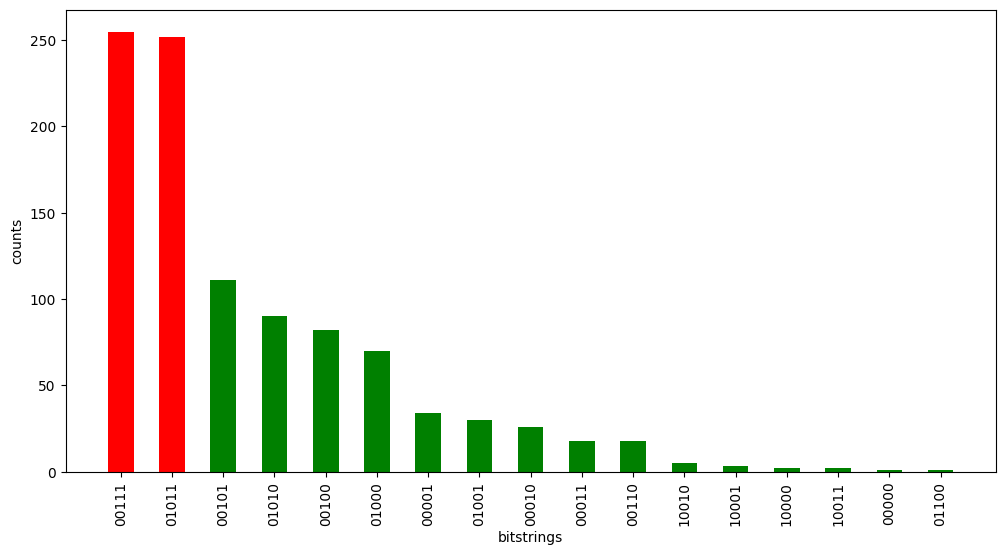

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import src.register_optimizer as regop
import src.QAOA_func as QAOA_func
import src.qubo as qb


def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = qb.get_cost(C, Q)
    return cost

def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)


shape = (len(Q), 2)

np.random.seed(0)


reg = regop.optimized_register(Q)
regop.draw_register(reg)

LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")


scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

optimal_count_dict = quantum_loop(params[np.argmin(scores)])

QAOA_func.plot_distribution(optimal_count_dict)

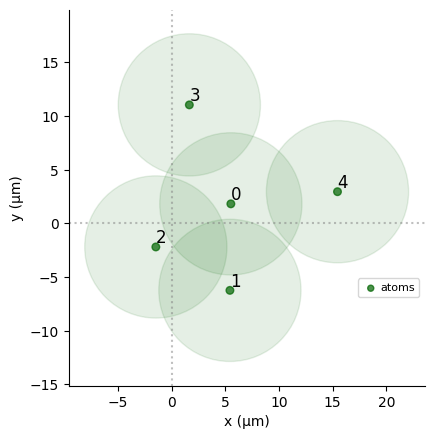

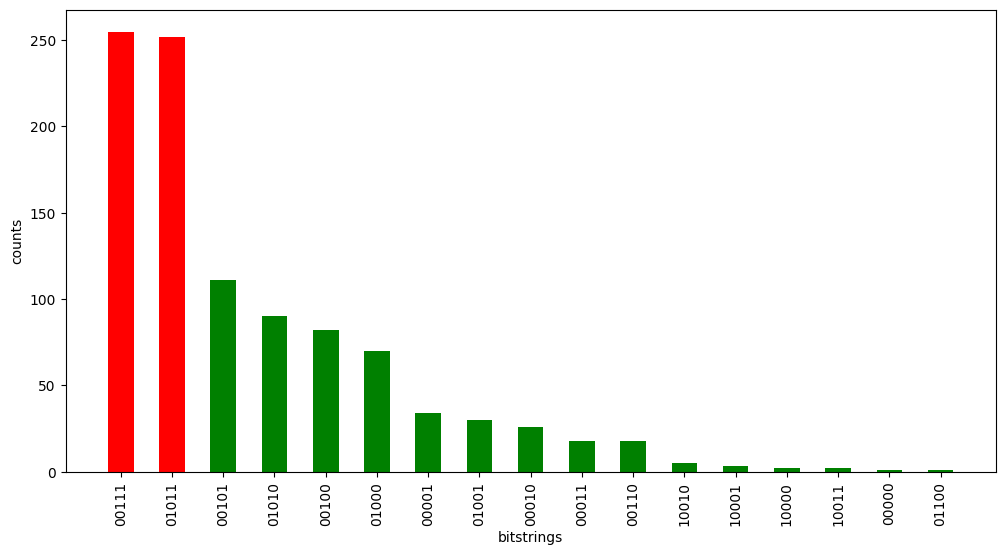

In [1]:
import src.QAOA as QAOA
import numpy as np

Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

QAOA.QAOA(Q)